# Sentiment Analysis using Naive Bayes

Naive Bayes algorithms are a set of supervised statistical classification machine learning algorithms based on the Bayes probability theorem.

Bayes theorem states that:

$$P(A|B) = \frac{P(B/A) * P(A)}{P(B)}$$
$$P(A|B) = \frac{P(B/A) * P(A)}{P(B/A) * P(A) + P(C/A) * P(A)}$$

An important assumption made by Bayes theorem is that the value of a particular feature is independent from the value of any other feature for a given the class.

For sentiment analysis on the given dataset, we have used the method "Bag of Words". In this method we create a dictionary/vocabulary of distinct words (which tells us about the sentiment of the sentence). Here, words are taken as features used to estimate the sentiment.

The prior probability of the positive and negative classes, along with, the probability of occurence of each word (feature) are calculated.

### Implementation
- All the sentences are preprocessed. The preprocessing includes:
    1. Removal of stop words such as 'a,the,is ...' which do not contribute to the semantics
    2. Removal of punctuation marks and numbers through regular expressions
- Once the preprocessing is done we then create a vocabulary using the training data
- The likelihoods of the words in the training data are calculated. Laplacian smoothing is used to prevent zero probability
- The testing sentences are then classified by calculating the posterior probabilities from the prior probabilities and likelihoods of the words.
- A 7-fold cross validation has been implemented to calculate the metrics.

## Packages

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Preprocessing

In [2]:
data = open('dataset_NB.txt', 'r')

<b>Insert data from txt file to a dictionary.
Sepearte out the Labels.</b>

In [3]:
dict_data = {'text':[], 'label':[]}
for line in data.readlines():
    label = line[-2]
    sentence = line[:-2]
    dict_data['text'].append(sentence)
    dict_data['label'].append(label)
dict_data['label'][-1] = '0'

In [4]:
dict_data['text'][:10]

['So there is no way for me to plug it in here in the US unless I go by a converter.  ',
 'Good case, Excellent value. ',
 'Great for the jawbone.  ',
 'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!! ',
 'The mic is great.   ',
 'I have to jiggle the plug to get it to line up right to get decent volume.  ',
 'If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one. ',
 'If you are Razr owner...you must have this! ',
 'Needless to say, I wasted my money. ',
 'What a waste of money and time!.    ']

In [5]:
dict_data['label'][:10]

['0', '1', '1', '0', '1', '0', '0', '1', '0', '0']

<b>Create a Dataframe with the data from "dict_data".
Then, visualize the data.</b>

In [6]:
df = pd.DataFrame(dict_data)

In [7]:
df

,text,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


<b>As shown below, there are 500 lines with postive and 500 lines with negitive sentiment.
This is an eqaully distributed dataset.</b>

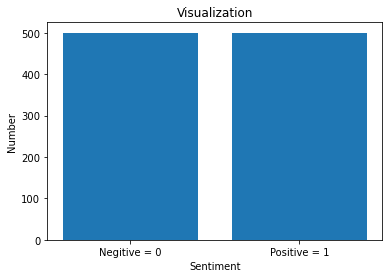

In [8]:
counts = df['label'].value_counts()
counts = counts.to_numpy()
plt.bar(['Negitive = 0','Positive = 1'], counts)
plt.xlabel('Sentiment')
plt.ylabel('Number')
plt.title('Visualization')
plt.show()

<b>Function Defined for processing the text data. This includes:
    <ol>
        <li>Removing stop words</li>
        <li>Removing commas, fullstops, hyphens</li>
        <li>Numerical Data</li>
    </ol>
</b>

In [9]:
def data_preprocess(textdata):
    processed =[]

    alphaPattern = r"[^\w\s]"
    numPattern = r"[\d]"
    sequenceFind = r"(.)\1\1+"
    sequenceReplace = r"\1\1"

    for line in textdata:
        line = line.lower()
        line = re.sub(alphaPattern, ' ', line)
        line = re.sub(numPattern, ' ', line)
        line = re.sub(sequenceFind, sequenceReplace, line)

        lineWords = ''
        for text in line.split():
            if len(text)>2:
                lineWords += (text +' ')

        processed.append(lineWords)

    return processed

In [10]:
dict_data['text'] = data_preprocess(dict_data['text'])

In [11]:
dict_data['text'][0:10]

['there way for plug here the unless converter ',
 'good case excellent value ',
 'great for the jawbone ',
 'tied charger for conversations lasting more than minutes major problems ',
 'the mic great ',
 'have jiggle the plug get line right get decent volume ',
 'you have several dozen several hundred contacts then imagine the fun sending each them one one ',
 'you are razr owner you must have this ',
 'needless say wasted money ',
 'what waste money and time ']

## Vectorizer

<b>Created a list of stop words, which do not contribute to the sentiment of a text.</b>

In [12]:
words = open('stop_words.txt', 'r')
stop_words = [word[:-1] for word in words.readlines()]

In [13]:
label = dict_data['label']
for i in range(0, len(label)): 
    label[i] = int(label[i]) 
dict_data['label'] = label

## Naive Bayes Model

<b>Prior Porbability:</b>
<br>
$$P(pos) = \frac{Count_{pos} + \alpha}{Count_{neg} + Count_{pos}} $$
<br>
<br>
$$P(neg) = \frac{Count_{neg} + \alpha}{Count_{neg} + Count_{pos}} $$
<br>
<b>Likelihood Porbability:</b>
<br>
<br>
$$parameters(pos) =P(W|pos) = \frac{Count(W)_{pos} + \alpha}{\sum{Count(W)_{pos}} + \alpha*V } $$
<br>
$$parameters(neg)=P(W|neg) = \frac{Count(W)_{neg} + \alpha}{\sum{Count(W)_{neg}} + \alpha*V} $$

<br><br>

<b>Posterior Probability</b>:
$$P(pos|(w1,w2....wn)) = \frac{P(pos)*\prod_{i=1}^{n}P(w_{i}|pos)}{P(pos)*\prod_{i=1}^{n}P(w_{i}|pos) + P(neg)*\prod_{i=1}^{n}P(w_{i}|neg)} $$
<br>
$$P(neg|(w1,w2....wn)) = \frac{P(neg)*\prod_{i=1}^{n}P(w_{i}|neg)}{P(pos)*\prod_{i=1}^{n}P(w_{i}|pos) + P(neg)*\prod_{i=1}^{n}P(w_{i}|neg)} 
$$


In [14]:
class NaiveBayesAlgo:

    def __init__(self, alpha=0.5):
        self.vocab={}
        self.prob_pos_words = {}
        self.prob_neg_words = {}  
        self.pos_count = 0
        self.neg_count = 0
        self.pos_prior = 0
        self.neg_prior = 0
        self.voc_len = 0
        self.alpha = alpha
        self.pos_word_count = 0
        self.neg_word_count = 0
    
    def vectorizer(self, data, label):
        '''
        Takes a list of sentences as input.
        Returns a dictionary containing unique words as keys and their respective count as values.
        '''
        dict_words = {}

        for line, label in zip(data, label):
            for word in line.split():
                if word not in stop_words:
                    if word in dict_words.keys():
                        dict_words[word][label]+=1
                    else:
                        dict_words[word] = {1:0, 0:0}
                        dict_words[word][label] += 1

        return dict_words
        
 
    def fit(self, X, Y, initialize=False):
        '''
        Parameters:
            X = List of input sentences
            Y = List of labels for input sentences
        '''
 
        if initialize:
            self.__init__()
        
        
        self.vocab = self.vectorizer(X, Y)
        self.voc_len = len(self.vocab.keys())
        
        # Loop through all the words in the vocabulary and get the counts of positive and negative words
        for word in self.vocab.keys():
            self.pos_word_count += self.vocab[word][1]
            self.neg_word_count += self.vocab[word][0]
            
        # Get the number of positive and negative samples
        self.pos_count = pd.DataFrame({'sentiments': Y})['sentiments'].value_counts()[1]
        self.neg_count = pd.DataFrame({'sentiments': Y})['sentiments'].value_counts()[0]
                        
        self.voc_len = len(list(self.vocab.keys()))
        
        # calculate likelihood propbabilities for both positive and negative classes
        for key in list(self.vocab.keys()):
            self.prob_pos_words[key] = (self.vocab[key][1] + self.alpha) / (self.pos_word_count + (self.alpha * self.voc_len))
            self.prob_neg_words[key] = (self.vocab[key][0] + self.alpha) / (self.neg_word_count + (self.alpha * self.voc_len))
 
        # calculate prior probabilities for both classes
        self.pos_prior = self.pos_count/(self.pos_count + self.neg_count)
        self.neg_prior = self.neg_count/(self.pos_count + self.neg_count)
        
        
    def predict(self, X):
        '''
        Parameters:
            X: List of input sentences
        Returns:
            y_true: list containing the predicted labels
        '''
        
        pos_prob = np.log(self.pos_prior)
        neg_prob = np.log(self.neg_prior)
        y_true=[]
        for i in range(len(X)):
            for word in X[i].split():
                if word in list(self.prob_pos_words.keys()):
                    pos_prob += np.log(self.prob_pos_words[word])
 
                if word in list(self.prob_neg_words.keys()):
                    neg_prob += np.log(self.prob_neg_words[word])
 
            if pos_prob >= neg_prob:
                y_true.append(1)
            else:
                y_true.append(0)
            pos_prob = self.pos_prior
            neg_prob = self.neg_prior
            
 
        return y_true


    def partition(self, data, fold, k):
        '''
        Partitions the given data into train and test data, such that the k-1 folds are taken as train and kth fold is taken as test.
        
        Parameters:
            data: Dictionary of values containing text and their sentiment labels, ie, 0 and 1.
            fold: index of fold to be taken as test.
            k: number of folds
        Returns:
            X_train: training samples
            X_test: testing samples
            Y_train: training labels
            Y_test: testing labels
        '''
        
        size = len(dict_data['text'])
        start = int((size/k)*fold)
        end = int((size/k)*(fold+1))
        
        X_test = data['text'][start:end]
        Y_test = data['label'][start:end]
        
        vector = np.array(data['text'])
        X_train = np.concatenate((vector[:start], vector[end:]))
        vector = np.array(data['label'])
        Y_train = np.concatenate((vector[:start], vector[end:]))
        
        return X_train, X_test, Y_train, Y_test
    
    
    def cross_val(self, data, k):
        '''
        Performs k-fold validation on the given data.
        
        Parameters:
            data: Dictionary of values containing text and their sentiment labels, ie, 0 and 1.
            k: No. of folds
        '''
        
        TP, TN, FP, FN, Total, accuracy, recall, precision=0, 0, 0, 0, 0, 0, 0, 0
        
        for i in range(k):
            
            X_train, X_test, Y_train, Y_test = self.partition(data, i, k)            
            
            self.fit(X_train, Y_train, initialize=True)
            
            y_pred = self.predict(X_test)
            dict = self.report(Y_test, y_pred)
            
            TP+=dict['TP']
            TN+=dict['TN']
            FP+=dict['FP']
            FN+=dict['FN']
            Total+=dict['Total']
            accuracy+=dict['Accuracy']
            precision+=dict['Precision']
            recall+=dict['Recall']
            
            self.evaluate(X_test, Y_test)
        
        avg = {'TP':TP/k, 'TN':TN/k, 'FP':FP/k, 'FN':FN/k, 'Total':Total/k, 'Accuracy':accuracy/k, 'Recall':recall/k, 'Precision':precision/k}
        
        print('Final Classification Report') 
        n = np.array(list(avg.items()))
        df = pd.DataFrame(n[:,1], index=n[:,0], columns=[''])
        print(df)
        self.confusion_matrix(avg)
        
    
    def evaluate(self, x_test, y_test):
        '''
        Evaluates the model for a given testing data
        Parameters:
            x_test: testing samples
            y_test: testing labels
        '''

        y_pred = self.predict(x_test)
        dict = self.report(y_pred, y_test)
        print('Classification Report') 
        n = np.array(list(dict.items()))
        df = pd.DataFrame(n[:,1], index=n[:,0], columns=[''])
        print(df)
        self.confusion_matrix(dict)
        
    
    def report(self, y_pred, y_test):
        '''
        calculates precision and recall metrics
        Parameters:
            y_pred: predicted labels on a testing set
            y_test: true labels of the testing set
        '''
        
        TP=0
        TN=0
        FP=0
        FN=0
        Total=len(y_pred)
        for pred, test in zip(y_pred, y_test):
            if pred==test:
                if pred==0:
                    TN+=1
                else:
                    TP+=1
            else:
                if pred==1:
                    FP+=1
                else:
                    FN+=1
        
        accuracy = (TP+TN) / Total
        recall = TP / (TP+FN)
        precision = TP / (TP+FP)
        
        return {'TP':TP, 'TN':TN, 'FP':FP, 'FN':FN, 'Total':Total, 'Accuracy':accuracy, 'Recall':recall, 'Precision':precision}
        
    def confusion_matrix(self, report_val):
        '''
        Plots the confusion Matrix of the given data.
        '''
        
        fig, ax = plt.subplots()
        classes = ['Positive', 'Negitive']
        t = report_val['Total']
        report = np.array([[report_val['TN']/t, report_val['FP']/t], [report_val['FN']/t, report_val['TP']/t]])
        im = ax.imshow(report, cmap = 'Blues')

        ax.set_xticks(np.arange(len(classes)))
        ax.set_yticks(np.arange(len(classes)))

        ax.set_xticklabels(classes)
        ax.set_yticklabels(classes)


        plt.setp(ax.get_xticklabels(), rotation_mode="anchor")
        
        group_names = ['True Neg','False Pos', 'False Neg','True Pos']
        group_percentages = ['{0:.2%}'.format(value) for value in report.flatten()]

        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)

        for i in range(len(classes)):
            for j in range(len(classes)):
                text = ax.text(j, i, labels[i, j], ha="center", va="center")

        ax.set_title('Confusion Matrix', fontdict = {'size':18}, pad = 20)
        
        fig.tight_layout()
        plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
        plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
        plt.show()
        

## Training

In [15]:
NB = NaiveBayesAlgo()

<b> Training and evaluating the model with train and test data, which have sizes in the ratio 7:3. This is 2-fold cross validation.
Done to test the model.</b>

## Cross Validation

Classification Report
                             
TP                         69
TN                         46
FP                         19
FN                          8
Total                     142
Accuracy   0.8098591549295775
Recall     0.8961038961038961
Precision  0.7840909090909091


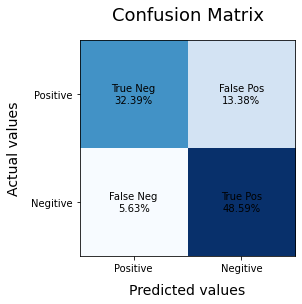

Classification Report
                             
TP                         66
TN                         55
FP                         15
FN                          7
Total                     143
Accuracy   0.8461538461538461
Recall     0.9041095890410958
Precision  0.8148148148148148


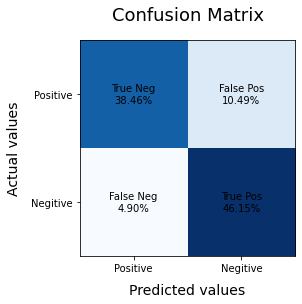

Classification Report
                             
TP                         66
TN                         52
FP                         16
FN                          9
Total                     143
Accuracy   0.8251748251748252
Recall                   0.88
Precision  0.8048780487804879


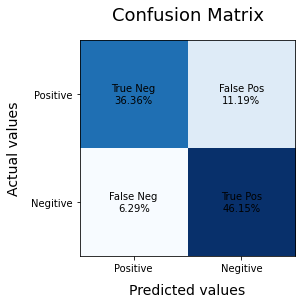

Classification Report
                             
TP                         63
TN                         47
FP                         24
FN                          9
Total                     143
Accuracy   0.7692307692307693
Recall                  0.875
Precision  0.7241379310344828


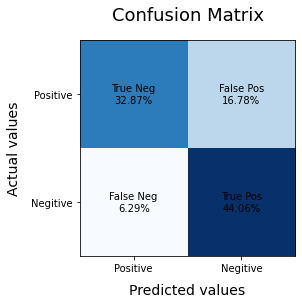

Classification Report
                             
TP                         55
TN                         62
FP                         15
FN                         11
Total                     143
Accuracy   0.8181818181818182
Recall     0.8333333333333334
Precision  0.7857142857142857


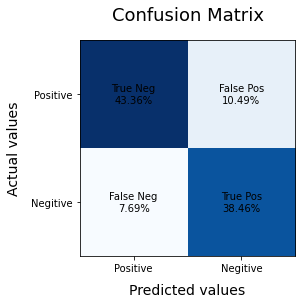

Classification Report
                             
TP                         59
TN                         54
FP                         19
FN                         11
Total                     143
Accuracy   0.7902097902097902
Recall     0.8428571428571429
Precision  0.7564102564102564


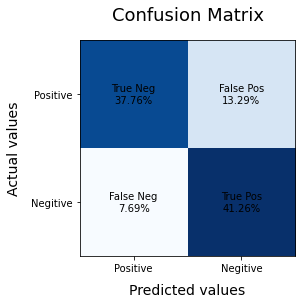

Classification Report
                             
TP                         52
TN                         60
FP                         16
FN                         15
Total                     143
Accuracy   0.7832167832167832
Recall     0.7761194029850746
Precision  0.7647058823529411


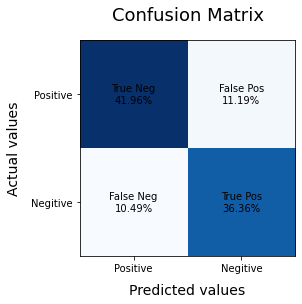

Final Classification Report
                             
TP          61.42857142857143
TN         53.714285714285715
FP                       10.0
FN         17.714285714285715
Total      142.85714285714286
Accuracy   0.8060038552996299
Recall     0.7763931611711683
Precision  0.8582176234743633


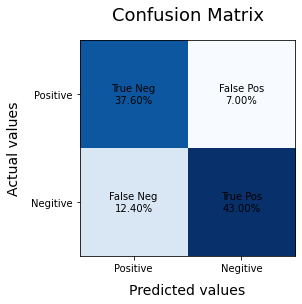

In [16]:
NB.cross_val(dict_data, 7)

<b>Final Classification Report</b>

Average values after 7-Fold Cross Validation:

- Accuracy 80.60%
- Recall 77.63%
- Precision 85.82%
  
  
 Note: The final classification report is given by the last heatmap

## Predict using custom sentences

A custom sentence can be typed over here to predict the sentiment

In [17]:
test = ['there way for plug here the unless converter ',
 'good case excellent value ',
 'great for the jawbone ']
NB.predict(test)

[0, 1, 1]

## Limitations of Naive Bayes Classifier

- Naive Bayes does not consider the semantic relation between the words in a sentence i.e, Naive Bayes assumes that all features are independent. However in real world scenario it is rare that features occur independently

- Smoothening techniques need to be used to prevent 'zero-probability' problem.

- In Natural Language Processing the sequence of words play a huge role in the semantics of a sentence. This aspect is ignored by the Naive Bayes algorithm

- In some tasks,the estimations can be wrong, methods other than probability outputs should be considered.